# Topic Modeling #

Jusqu'à maintenant, nous avons fait de la classification non supervisée, où l'ordinateur distribuait librement chaque document en fonction de la répartition de ses mots.

Nous allons ici développer un peu cela en faisant du topic modeling : cette fois-ci, chaque mot est assimilé à un sujet (ou plus précisément à une variété de sujets dont la proximité est donnée sous la forme d'une coefficient relatif à chacun des sujets), et l'addition de chacun de ces coefficients pour chaque mot détermine pour chaque abstract un sujet (ou plutôt une liste de thèmes dont la proximité est indiquée sous la forme d'un coefficient). Grâce à cela, on peut déterminer des clusters fondés non plus la répétitivité de certains termes ou de certaines constructions, mais sur les champs lexicaux utilisés.

Nous nous appuierons pour cela sur divers librairies qu'il convient d'importer.

## Les packages ##

In [4]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#Permet d'utiliser LDA Mallet dans la seconde partie de l'analyse
import git
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Les stopwords ##

Je définis des stopwords, c'est à dire la liste de mots qui ne doivent pas être pris en compte, ces mots étant généralement des mots grammaticaux. Les mots grammaticaux sont généralement très nombreux mais portent un très faible poids sémantique. Il faut donc les retirer pour éviter qu'ils n'occultent les autres mots à cause de leur surreprésentation.

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) #permet d'ajouter certains termes que j'ai décrété

## Choisir son corpus ##

Il faut activer l'une des deux cellules (au choix) pour charger en mémoire le corpus traité de la manière que vous voulez.

Le meilleur choix pour un premier test est de choisir le texte lemmatisé.

In [6]:
#Pour utiliser les textes lemmatisés, c'est ici
import os
documents = []
Path = "./cache2019/cacheLEM/"
filelist = os.listdir(Path) #filelist est une liste regroupant tous les chemins vers les différents abstracts.

for abstract in filelist:
    with open(Path + abstract, "r", encoding="UTF-8") as y:
        texte = y.read()
        documents.append(texte)

## Topic modeling partie 1 : définir des topic ##

### Séquençage et nettoyage ###

Tout d'abord, je définis une fonction qui séquence chaque abstract en mot et retire la ponctuation. C'est l'étape du préprocessing, c'est à dire formatter le document afin de le rendre lisible par gensim. Gensim a sa propre méthode de séquençage, que nous utiliserons.

Chaque document, sous la forme d'une str, devient une liste de str.

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(documents))

print(data_words[:1])

[['use', 'machine', 'learn', 'for', 'the', 'automated', 'classification', 'of', 'stage', 'directions', 'in', 'tei', 'encode', 'drama', 'corpora', 'authors', 'daria', 'maximova', 'national', 'research', 'university', 'higher', 'school', 'of', 'economics', 'moscow', 'ru', 'frank', 'fischer', 'dariah', 'eu', 'and', 'national', 'research', 'university', 'higher', 'school', 'of', 'economics', 'moscow', 'ru', 'abstract', 'the', 'stage', 'tag', 'be', 'core', 'element', 'for', 'the', 'encoding', 'of', 'drama', 'the', 'tei', 'guideline', 'suggest', 'nine', 'value', 'for', 'pron', 'type', 'attribute', 'which', 'be', 'widely', 'use', 'in', 'large', 'corpus', 'such', 'as', 'the', 'french', 'theatre', 'classique', 'the', 'shakespeare', 'folger', 'library', 'or', 'the', 'swedish', 'dramawebben', 'this', 'paper', 'introduce', 'an', 'approach', 'to', 'automatically', 'assign', 'stage', 'direction', 'type', 'to', 'the', 'tei', 'encoded', 'russian', 'drama', 'corpus', 'rusdracor', 'https', 'dracor', 'or

### Construire les bigrammes et les trigrammes ###

Nous allons maintenant construire les bigrammes et les trigrammes, c'est à dire rassembler les mots par groupe de 2 ou 3 en fonction de leur ressemblance sémantique, permettant de dégager ainsi des débuts de regroupement.

Nous créons donc les modèles pour créer les bigrammes et les trigrammes, qui donnent une liste de mots assignés à chaque mot un à un. Nous testons à la fin un exemple de la liste de mot.

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['use', 'machine', 'learn', 'for', 'the', 'automated', 'classification', 'of', 'stage', 'directions', 'in', 'tei', 'encode', 'drama', 'corpora', 'authors', 'daria', 'maximova', 'national', 'research', 'university', 'higher', 'school', 'of', 'economics', 'moscow', 'ru', 'frank', 'fischer', 'dariah', 'eu', 'and', 'national', 'research', 'university', 'higher', 'school', 'of', 'economics', 'moscow', 'ru', 'abstract', 'the', 'stage', 'tag', 'be', 'core', 'element', 'for', 'the', 'encoding', 'of', 'drama', 'the', 'tei', 'guideline', 'suggest', 'nine', 'value', 'for', 'pron', 'type', 'attribute', 'which', 'be', 'widely', 'use', 'in', 'large', 'corpus', 'such', 'as', 'the', 'french', 'theatre', 'classique', 'the', 'shakespeare', 'folger', 'library', 'or', 'the', 'swedish', 'dramawebben', 'this', 'paper', 'introduce', 'an', 'approach', 'to', 'automatically', 'assign', 'stage_direction', 'type', 'to', 'the', 'tei', 'encoded', 'russian', 'drama', 'corpus', 'rusdracor', 'https', 'dracor', 'org', 

Nous insérons ensuite les modèles dans des fonctions :

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Puis ensuite nous l'appliquons à notre set de textes.

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['machine', 'learn', 'automate', 'classification', 'stage', 'direction', 'encode', 'high', 'school', 'economic', 'high', 'school', 'economic', 'abstract', 'stage', 'tag', 'core', 'element', 'encode', 'drama', 'guideline', 'suggest', 'value', 'pron', 'type', 'attribute', 'widely', 'large', 'paper', 'introduce', 'approach', 'automatically', 'assign', 'stage_direction', 'type', 'encode', 'russian', 'drama', 'currently', 'feature', 'play', 'range', 'mid', 'make', 'stage_direction', 'token', 'select', 'play', 'comprise', 'stage_direction', 'represent', 'manual', 'annotation', 'pron', 'establish', 'clear', 'set', 'rule', 'identify', 'stage_direction', 'type', 'propose', 'guideline', 'stage', 'develop', 'tool', 'classification', 'remain', 'play', 'human', 'interference', 'conversion', 'stage_direction', 'feature', 'vector', 'morphological', 'able', 'classify', 'different', 'type', 'score', 'approx', 'mean', 'stage_direction', 'give', 'type', 'assign', 'correctly', 'pron', 'work', 'inform', '

Ensuite, les mots de chaque texte sont encodés sous la forme de tuple où le premier entier est son identifiant et où le second est son nombre d'occurences.

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 2), (27, 1), (28, 3), (29, 1), (30, 1), (31, 2), (32, 1), (33, 2), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 3), (50, 1), (51, 3), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 3), (64, 8), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 5), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1)]]


Pour mieux le comprendre, voici une visualisation adaptée à un être humain :

In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('abstract', 1),
  ('allow', 1),
  ('analysis', 1),
  ('annotation', 1),
  ('approach', 1),
  ('approx', 1),
  ('assign', 2),
  ('attribute', 1),
  ('automate', 1),
  ('automatically', 1),
  ('base', 1),
  ('classification', 2),
  ('classify', 1),
  ('clear', 1),
  ('comprise', 1),
  ('conversion', 1),
  ('core', 1),
  ('correctly', 1),
  ('currently', 1),
  ('dedicated', 1),
  ('description', 1),
  ('develop', 1),
  ('different', 1),
  ('direction', 1),
  ('drama', 2),
  ('economic', 2),
  ('element', 1),
  ('encode', 3),
  ('establish', 1),
  ('evolvement', 1),
  ('feature', 2),
  ('give', 1),
  ('guideline', 2),
  ('high', 2),
  ('human', 1),
  ('identify', 1),
  ('inform', 1),
  ('interference', 1),
  ('introduce', 1),
  ('large', 2),
  ('learn', 1),
  ('machine', 1),
  ('make', 1),
  ('manual', 1),
  ('mean', 1),
  ('mid', 1),
  ('morphological', 1),
  ('paper', 1),
  ('play', 3),
  ('preliminary', 1),
  ('pron', 3),
  ('propose', 1),
  ('range', 1),
  ('remain', 

### Construire l'attribution des sujets ###

La LDA (latent Dirichlet Allocation) est une méthode permettant de définir que si certains thèmes sont observés dans un corpus, nous pouvons alors dire que chacun des mots du corpus peuvent être attribués à l'un de ces thèmes. Nous initialisons alors ce modèle.

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1, #update_every determines how often the model parameters should be updated and
                                           chunksize=100, #chunksize is the number of documents to be used in each training chunk.
                                           passes=10, #passes is the total number of training passes
                                           alpha='auto',
                                           per_word_topics=True)

Nous pouvons alors trouver les mots clés les plus pertinents de chaque cluster que la machine a trouvé :

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"database" + 0.015*"information" + 0.015*"also" + 0.012*"footnote" + '
  '0.012*"research" + 0.012*"platform" + 0.012*"datum" + 0.009*"letter" + '
  '0.009*"annotation" + 0.009*"reference"'),
 (1,
  '0.020*"pron" + 0.019*"text" + 0.018*"collection" + 0.016*"new" + '
  '0.013*"work" + 0.012*"often" + 0.011*"exist" + 0.009*"single" + '
  '0.009*"scholar" + 0.009*"attempt"'),
 (2,
  '0.023*"text" + 0.021*"network" + 0.018*"pointer" + 0.013*"analysis" + '
  '0.013*"encode" + 0.013*"way" + 0.013*"type" + 0.013*"attribute" + '
  '0.013*"uri" + 0.010*"project"'),
 (3,
  '0.001*"pron" + 0.001*"text" + 0.001*"project" + 0.001*"element" + '
  '0.001*"process" + 0.001*"editor" + 0.001*"encode" + 0.001*"work" + '
  '0.001*"type" + 0.001*"build"'),
 (4,
  '0.001*"text" + 0.001*"encode" + 0.001*"pron" + 0.001*"document" + '
  '0.001*"project" + 0.001*"process" + 0.001*"also" + 0.000*"build" + '
  '0.000*"model" + 0.000*"make"'),
 (5,
  '0.015*"project" + 0.015*"create" + 0.015*"deploy"

### Critique du calcul : le score de cohérence ###

La perplexité et le score de cohérence permettent de définir si les groupes générés par topic sont cohérents, c'est à dire s'il y a trop ou pas assez de groupes, et si les groupes sont vraiment représentés par ce topic, si ce topic est vraiment au coeur des textes.

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.410481029171234

Coherence Score:  0.30713129916167237


### Visualisation ###

Grâce à cette carte interactive, nous pouvons visualiser la répartition des thèmes et des mots-clés dans chaque cluster.

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.084124  0.042834       1        1  34.859734
11    -0.126215  0.103909       2        1  15.901484
9     -0.128645 -0.120374       3        1  13.758124
17    -0.165462 -0.016047       4        1  11.205426
18    -0.132344 -0.111915       5        1   4.780513
13    -0.055596 -0.016904       6        1   3.450002
19    -0.045512  0.157939       7        1   3.391270
15    -0.011728  0.091103       8        1   2.852452
2      0.024837  0.020276       9        1   2.100884
0      0.045039 -0.025121      10        1   1.657712
1      0.054709 -0.012421      11        1   1.521145
16     0.062357 -0.028484      12        1   1.278617
5      0.055071 -0.047193      13        1   1.118663
14     0.045413 -0.004908      14        1   1.087766
12     0.059054  0.016826      15        1   0.995153
7      0.081418 -0.010264      16        1   0.008319
3      0.076594 -0.008367      17        1   0.008295
10     0.079526 -0.009815      18        1   0.008215
4      0.084626 -0.011312      19        1   0.008136
8      0.080983 -0.009762      20        1   0.008098, topic_info=          Term        Freq       Total Category  logprob  loglift
146       text  271.000000  271.000000  Default  30.0000  30.0000
48       paper   75.000000   75.000000  Default  29.0000  29.0000
51        pron  198.000000  198.000000  Default  28.0000  28.0000
28      encode  129.000000  129.000000  Default  27.0000  27.0000
133    project   88.000000   88.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
144  structure    0.000502   41.506618  Topic20  -7.6421  -1.9015
43        make    0.000505   55.495518  Topic20  -7.6354  -2.1854
417    provide    0.000504   49.948055  Topic20  -7.6380  -2.0826
118       line    0.000496   59.710567  Topic20  -7.6548  -2.2779
97    describe    0.000494   37.526176  Topic20  -7.6578  -1.8165

[1390 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2255      9  0.814394     abbasid
604       9  0.814987  abbreviate
0         1  0.188387        able
0         4  0.565161        able
0         5  0.125591        able
...     ...       ...         ...
75        2  0.712408        year
75        4  0.203545        year
75        7  0.101773        year
1557      3  0.491640       yield
1557     12  0.491640       yield

[2002 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 12, 10, 18, 19, 14, 20, 16, 3, 1, 2, 17, 6, 15, 13, 8, 4, 11, 5, 9])

## LDA Mallet Model ##

### Passage de l'algorithme de Gensim à celui de Mallet ###

Pour la suite, nous utiliserons l'algorithme de topic modeling de Mallet plutôt que celui proposé par Gensim. Bien que Gensim offre une meilleure approche de Topic Modeling, car chaque étape est bien séparée et peut être personnalisée (nettoyage de la donnée ou *preprocessing*, construction et paramètrage du modèle de Topic Modeling), l'algorithme de Topic Modeling proposé par Mallet est un peu plus précis que celui de Gensim, en offrant notamment une meilleure qualité de sujets.

En 2014 Radim Řehůřek, créateur de Gensim, a créé un Wrapper permettant d'utiliser l'algorithme de Mallet. Nous allons donc télécharger les dossiers de Mallet depuis GitHub et utiliser ce wrapper pour utiliser l'algorithme de Mallet.

In [34]:
if not os.path.exists('./cache2019/Mallet'):
    git.Git("./cache2019").clone("git clone https://github.com/mimno/Mallet.git")

mallet_path = "./cache2019/Mallet/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

Les Topics mesurés sont légèrement différents :

In [37]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(10,
  [('encode', 0.05112474437627812),
   ('research', 0.04294478527607362),
   ('author', 0.04294478527607362),
   ('event', 0.0408997955010225),
   ('history', 0.034764826175869123),
   ('common', 0.028629856850715747),
   ('make', 0.026584867075664622),
   ('propose', 0.026584867075664622),
   ('focus', 0.024539877300613498),
   ('analysis', 0.022494887525562373)]),
 (18,
  [('line', 0.07174231332357248),
   ('poem', 0.05124450951683748),
   ('rhyme', 0.04978038067349927),
   ('encode', 0.04685212298682284),
   ('tag', 0.03953147877013177),
   ('encoder', 0.02635431918008785),
   ('night', 0.021961932650073207),
   ('process', 0.021961932650073207),
   ('label', 0.01903367496339678),
   ('feature', 0.01903367496339678)]),
 (19,
  [('project', 0.11598746081504702),
   ('database', 0.06426332288401254),
   ('datum', 0.05172413793103448),
   ('require', 0.047021943573667714),
   ('structure', 0.03918495297805643),
   ('tool', 0.02664576802507837),
   ('metadata', 0.02351097178683385

Nous pouvons comparer le score de cohérence de ces algorithmes :

In [36]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score of LDA Mallet : ', coherence_ldamallet)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score of LDA Gensim : ', coherence_lda)


Coherence Score of LDA Mallet :  0.3628188984137969

Coherence Score of LDA Gensim :  0.30713129916167237


Comme on peut le voir, Mallet est légèrement meilleur que Gensim. Il y a donc un certain intérêt à continuer avec Mallet.

### Critique du choix du nombre de clusters ###

Nous allons ici voir si le nombre de clusters choisi est vraiment représentatif et optimal. Pour calculer cela, nous nous baserons sur la " cohérence ", un coefficient calculé par l'ordinateur. Tout d'abord, nous créons une fonction permettant de calculer la cohérence :

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Puis nous cherchons à voir si cela est vraiment cohérent. Nous appliquons cette fonction au corpus. La fonction lancée ci-dessous va attribuer à chaque "model_list", une élément propre à Gensim regroupant la liste des topics attribués à un corpus (élément copié sur celui de Mallet mais avec cet avantage de ne pas stocker dans la RAM les textes, allégeant grandement le processus) la variable "coherence_values" qui est une liste constituée de nombres décimaux représentant la cohérence de chaque topic.

In [21]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Puis nous affichons le résultat sous la forme d'un graphique :

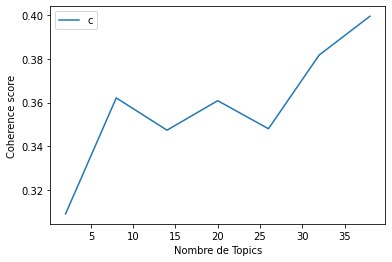

In [38]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Nombre de Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Nous voyons qu'il y a un pic à 8 topics, un autre à 20, puis à partir de 32 topics le score de cohérence monte en flèche. Le pic à 8 topics est intéressant, car c'est le nombre de " topics " différents proposés lors de la Conférence TEI 2019. L'augmentation finale permet cependant de comprendre que les abstracts restent relativement peu liés les uns aux autres, et que le nombre optimal de topics pour l'ordinateur serait d'un topic par abstract...

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.309
Num Topics = 8  has Coherence Value of 0.3621
Num Topics = 14  has Coherence Value of 0.3473
Num Topics = 20  has Coherence Value of 0.3608
Num Topics = 26  has Coherence Value of 0.348
Num Topics = 32  has Coherence Value of 0.3817
Num Topics = 38  has Coherence Value of 0.3995


### Voir les topics ###

La cellule ci-dessous permet d'afficher pour chaque topic (représenté par un nombre entier) les 10 mots-clés représentant le mieux ce topic, et un facteur attribué à chacun de ces mots permettant de voir l'importance de chaque mot-clé au sein du cluster.

In [24]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.054*"event" + 0.052*"attribute" + 0.052*"type" + 0.033*"performance" + '
  '0.033*"guideline" + 0.025*"editorial" + 0.025*"formal" + 0.022*"pointer" + '
  '0.022*"attempt" + 0.022*"stage_direction"'),
 (1,
  '0.065*"type" + 0.051*"feature" + 0.049*"structure" + 0.045*"large" + '
  '0.041*"give" + 0.037*"historical" + 0.029*"publish" + 0.025*"context" + '
  '0.024*"good" + 0.024*"content"'),
 (2,
  '0.068*"document" + 0.062*"make" + 0.043*"high" + 0.032*"early" + '
  '0.032*"print" + 0.027*"quality" + 0.025*"propose" + 0.025*"research" + '
  '0.025*"complex" + 0.025*"edition"'),
 (3,
  '0.088*"editor" + 0.050*"transformation" + 0.045*"encode" + 0.033*"create" + '
  '0.031*"parliamentary" + 0.031*"record" + 0.028*"description" + 0.026*"part" '
  '+ 0.024*"comment" + 0.017*"edit"'),
 (4,
  '0.064*"element" + 0.042*"level" + 0.040*"odd" + 0.028*"language" + '
  '0.025*"source" + 0.019*"component" + 0.019*"literary" + 0.018*"title" + '
  '0.018*"eltec" + 0.014*"variation"'),
 (5,


### Visualisation ###

Nous allons produire sous la forme d'un tableau le sujet dominant de chaque texte.

In [26]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1663,"event, attribute, type, performance, guideline...",use machine learn for the Automated Classifica...
1,1,13.0,0.1530,"format, web, offer, accessible, principle, sea...",TEI XML and Delta Format Interchangeability TE...
2,2,12.0,0.3391,"encode, letter, develop, metadata, base, editi...",correspsearch v2 – new way of explore correspo...
3,3,9.0,0.3121,"project, datum, database, work, tool, focus, s...",get along with Relational Databases Background...
4,4,14.0,0.2901,"file, provide, access, datum, change, process,...",introduce objectification : when be an < objec...
5,5,7.0,0.1602,"set, number, token, information, word, advanta...",analyze and Visualizing Uncertain Knowledge : ...
6,6,0.0,0.3769,"event, attribute, type, performance, guideline...",reference an editorial ontology from the TEI :...
7,7,14.0,0.1200,"file, provide, access, datum, change, process,...",case Study TEI Customization : a restrict TEI ...
8,8,4.0,0.2905,"element, level, odd, language, source, compone...",in search of comity : TEI for distant read Int...
9,9,0.0,0.3174,"event, attribute, type, performance, guideline...",reconceive TEI model of theatrical performance...


Puis nous allons trouver l'abstract le plus représentatif de chaque topic.

In [27]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3769,"event, attribute, type, performance, guideline...",reference an editorial ontology from the TEI :...
1,1.0,0.3607,"type, feature, structure, large, give, histori...",make linkable Data from Account Books : Bookke...
2,2.0,0.4603,"document, make, high, early, print, quality, p...",create high - quality print from TEI document ...
3,3.0,0.4286,"editor, transformation, encode, create, parlia...",challenge in encode parliamentary datum : betw...
4,4.0,0.2905,"element, level, odd, language, source, compone...",in search of comity : TEI for distant read Int...


Nous allons maintenant regarder le nombre de documents par topic :

In [28]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"event, attribute, type, performance, guideline...",4.0,0.0870
1.0,13.0,"format, web, offer, accessible, principle, sea...",3.0,0.0652
2.0,12.0,"encode, letter, develop, metadata, base, editi...",1.0,0.0217
3.0,9.0,"project, datum, database, work, tool, focus, s...",4.0,0.0870
4.0,14.0,"file, provide, access, datum, change, process,...",1.0,0.0217
5.0,7.0,"set, number, token, information, word, advanta...",1.0,0.0217
6.0,0.0,"event, attribute, type, performance, guideline...",1.0,0.0217
7.0,14.0,"file, provide, access, datum, change, process,...",3.0,0.0652
8.0,4.0,"element, level, odd, language, source, compone...",1.0,0.0217
9.0,0.0,"event, attribute, type, performance, guideline...",4.0,0.0870
